In [4]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
import matplotlib.pyplot as plt

# Load the data
stock = pd.read_csv('../Data/AAPL.csv')

# Parameters
window_size = 50
num_features = 1

# Prepare input and output data
X = [np.array([(stock.iloc[i + j, 4] - stock["Close"][i]) / stock["Close"][i] for j in range(window_size)]).reshape(window_size, 1) for i in range(len(stock) - window_size - 1)]
Y = [np.array([(stock.iloc[i + window_size, 4] - stock["Close"][i]) / stock["Close"][i]]).reshape(1, 1) for i in range(len(stock) - window_size - 1)]

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)

# Number of training samples
n_train = len(X_train)

# Convert the data to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], 50, 1)
X_test = X_test.reshape(X_test.shape[0], 50, 1)

In [5]:
# Create the model using Sequential API
model = Sequential()

# Bidirectional GRU layer
model.add(GRU(units=200, return_sequences=True, input_shape=(window_size, num_features)))
model.add(Dropout(0.5))

# Bidirectional GRU layer
model.add(GRU(units=200))
model.add(Dropout(0.5))

# Dense layer for single output (predicted price)
model.add(Dense(1, activation="linear"))

# Compile the model for regression task (mse loss, mae metric)
model.compile(optimizer='RMSprop', loss='mse')

# Display model summary
model.summary()

# Fit the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=40, batch_size=64, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 50, 200)           121800    
                                                                 
 dropout_2 (Dropout)         (None, 50, 200)           0         
                                                                 
 gru_3 (GRU)                 (None, 200)               241200    
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 363201 (1.39 MB)
Trainable params: 363201 (1.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
85/85 [

19/19 [==============================] - 1s 21ms/step


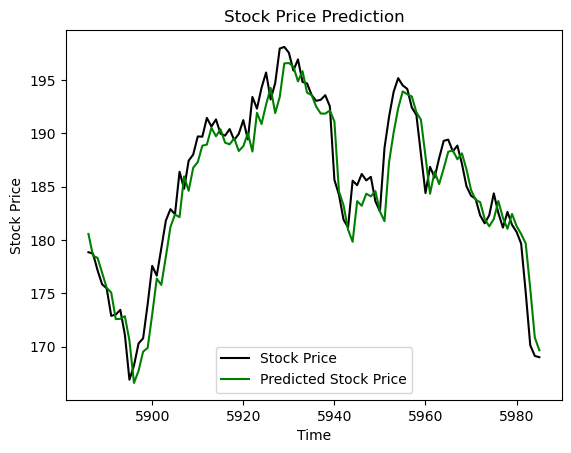

In [6]:
# Predict the stock price
predicted = model.predict(X_test)
predicted = np.array(predicted[:, 0]).reshape(-1, 1)

Y_test_to_plot = Y_test[:, 0]

# Convert predicted and test_label back to original scale
temp = stock["Close"][n_train:n_train+len(X_test)]
Y_test_to_plot = np.multiply(Y_test_to_plot.flatten(), temp) + np.array(temp)
predicted = np.multiply(predicted.flatten(), temp) + np.array(temp)
    

# Plot the results
plt.plot(Y_test_to_plot[-100:], color='black', label='Stock Price')
plt.plot(predicted[-100:], color='green', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [7]:
# Build a simple trading strategy

initial_capital = 1000000  # Initial capital
current_capital = initial_capital  # Current capital
shares = 0  # Number of shares initially owned

# Iterate through each day's data
for i in range(len(Y_test_to_plot) - 1):
    real_price_today = Y_test_to_plot.iloc[i]  # Real price today
    predicted_price_tomorrow = predicted.iloc[i + 1]  # Predicted price tomorrow

    if predicted_price_tomorrow > real_price_today:
        # Buy as many shares as possible with available capital
        shares_to_buy = current_capital // real_price_today
        shares += shares_to_buy
        current_capital -= shares_to_buy * real_price_today

    elif predicted_price_tomorrow < real_price_today:
        # Sell all shares
        current_capital += shares * real_price_today
        shares = 0

# At the end of the simulation, calculate the final amount based on the last day's real price
final_amount = current_capital + shares * Y_test_to_plot.iloc[-1]
return_percentage = (final_amount - initial_capital) / initial_capital * 100
num_days = len(Y_test_to_plot) - 1

print("Final amount:", final_amount)
print("Return percentage:", return_percentage)
print("Number of days:", num_days)

Final amount: 1292944.6436990013
Return percentage: 29.29446436990013
Number of days: 598


In [11]:
Y_test_to_plot

5387    148.759995
5388    149.259995
5389    149.479996
5390    148.690002
5391    148.639999
           ...    
5981    179.660004
5982    175.100006
5983    170.119995
5984    169.119995
5985    169.000000
Name: Close, Length: 599, dtype: float64

In [9]:
predicted

5387    145.744287
5388    147.953212
5389    148.557875
5390    148.996955
5391    148.411874
           ...    
5981    180.558802
5982    179.683323
5983    175.437832
5984    170.843155
5985    169.648060
Name: Close, Length: 599, dtype: float64